In [2]:
! pip install seaborn

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

In [4]:
midi_dir = r"C:\Users\sugia\Desktop\UCSD\CSE 153\A2\maestro-v3.0.0\midi"
midi_paths = glob.glob(os.path.join(midi_dir, "*.midi"))
print(f"Found {len(midi_paths)} MIDI files.")

Found 1276 MIDI files.


In [5]:
def get_midi_duration(path):
    pm = pretty_midi.PrettyMIDI(path)
    return pm.get_end_time()

In [5]:
durations = []
for path in tqdm(midi_paths[:100]):
    durations.append(get_midi_duration(path))

100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


In [ ]:
# Shows the stats for how long each piece is in seconds. 
dur_series = pd.Series(durations)
print(dur_series.describe())

count     100.000000
mean      491.777630
std       382.333767
min        76.015625
25%       206.244466
50%       351.714193
75%       643.143880
max      1797.419271
dtype: float64


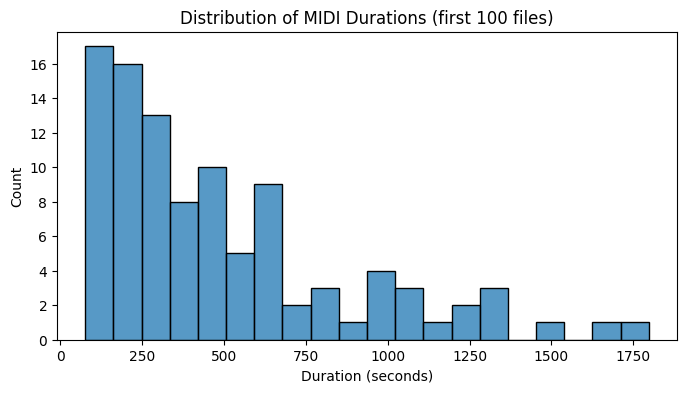

In [20]:
plt.figure(figsize=(8, 4))
sns.histplot(durations, bins=20)
plt.title('Distribution of MIDI Durations (first 100 files)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

In [9]:
records = []
for path in tqdm(midi_paths):
    pm = pretty_midi.PrettyMIDI(path)
    duration = pm.get_end_time()

    all_notes = [note for inst in pm.instruments for note in inst.notes]
    total_notes = len(all_notes)
    if total_notes > 0:
        velocities = np.array([note.velocity for note in all_notes])
        unique_pitches = len({note.pitch for note in all_notes})
        avg_velocity = velocities.mean()
        note_density = total_notes / duration
    else:
        unique_pitches = 0
        avg_velocity = np.nan
        note_density = 0

    records.append({
        'file': os.path.basename(path),
        'duration_s': duration,
        'total_notes': total_notes,
        'unique_pitches': unique_pitches,
        'avg_velocity': avg_velocity,
        'num_instruments': len(pm.instruments),
        'note_density': note_density
    })

100%|██████████| 1276/1276 [03:06<00:00,  6.82it/s]


In [10]:
df = pd.DataFrame(records)
df.head()
df.describe()

,duration_s,total_notes,unique_pitches,avg_velocity,num_instruments,note_density
count,1276.000000,1276.000000,1276.000000,1276.000000,1276.0,1276.000000
mean,561.412416,5517.369906,66.002351,63.910179,1.0,10.353929
std,443.032484,4236.924429,12.133344,6.372874,0.0,3.568568
min,45.160417,129.000000,25.000000,40.674863,1.0,1.454365
25%,262.577474,2348.500000,58.000000,60.194313,1.0,7.784387
50%,430.835286,4381.500000,69.000000,64.744738,1.0,9.850683
75%,685.559961,7279.500000,75.250000,68.572650,1.0,12.471133
max,2628.053385,25076.000000,88.000000,81.079620,1.0,21.388601


In [11]:
df.nlargest(10, 'note_density')[['file', 'note_density', 'total_notes', 'duration_s']]

,file,note_density,total_notes,duration_s
601,MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_0...,21.388601,2193,102.531250
37,MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AU...,21.285098,1618,76.015625
287,MIDI-Unprocessed_06_R1_2011_MID--AUDIO_R1-D2_1...,21.112824,2383,112.869792
519,MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AU...,20.987582,2423,115.449219
692,MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_19_R...,20.986003,6173,294.148438
72,MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_1...,20.873903,2432,116.509115
1175,ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_11_R1_20...,20.557684,6143,298.817708
716,MIDI-Unprocessed_20_R1_2009_01-05_ORIG_MID--AU...,20.499472,8043,392.351562
378,MIDI-Unprocessed_08_R1_2008_01-05_ORIG_MID--AU...,20.458153,1311,64.082031
484,MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_13_R...,20.423797,8266,404.723958


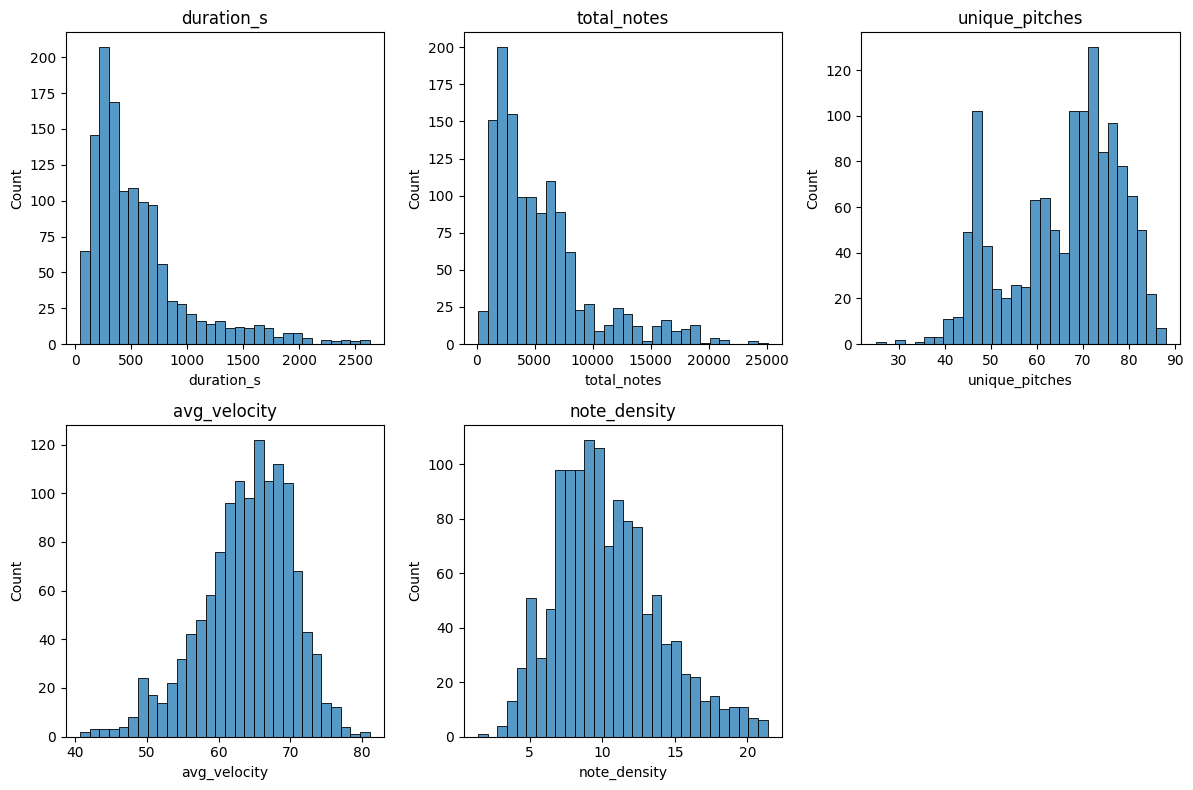

In [16]:
metrics = ['duration_s', 'total_notes', 'unique_pitches', 'avg_velocity', 'note_density']
plt.figure(figsize=(12, 8))
for i, m in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[m].dropna(), bins=30, kde=False)
    plt.title(m)
plt.tight_layout()
plt.show()

In [17]:
ext_records = []
for path in tqdm(midi_paths):
    pm = pretty_midi.PrettyMIDI(path)
    # Polyphony: sample time grid for active note counts
    times = np.linspace(0, pm.get_end_time(), num=500)
    active_counts = [sum(1 for inst in pm.instruments for note in inst.notes if note.start <= t < note.end) for t in times]
    max_poly = int(max(active_counts))
    avg_poly = float(np.mean(active_counts))

    # Tempo
    tempo_changes, tempi = pm.get_tempo_changes()
    mean_tempo = float(np.mean(tempi)) if len(tempi)>0 else np.nan
    tempo_range = float(np.max(tempi)-np.min(tempi)) if len(tempi)>1 else 0.0

    # Key and time signature events
    key_sigs = [ks.key_number for ks in pm.key_signature_changes]
    time_sigs = [(ts.numerator, ts.denominator) for ts in pm.time_signature_changes]
    key_mode = key_sigs[0] if key_sigs else None
    time_sig = time_sigs[0] if time_sigs else (None, None)

    # Note durations and IOIs
    note_durs = np.array([note.end-note.start for inst in pm.instruments for note in inst.notes])
    ioi = np.diff([note.start for inst in pm.instruments for note in inst.notes])
    dur_q = np.quantile(note_durs, [0.25, 0.5, 0.75]) if note_durs.size>0 else [np.nan]*3
    ioi_mean = float(np.mean(ioi)) if ioi.size>0 else np.nan
    ioi_var = float(np.var(ioi)) if ioi.size>0 else np.nan

    # Pitch-class histogram
    pitches = [note.pitch % 12 for inst in pm.instruments for note in inst.notes]
    pc_hist = np.bincount(pitches, minlength=12)
    pc_hist_norm = pc_hist / pc_hist.sum() if pc_hist.sum()>0 else pc_hist

    ext_records.append({
        'file': os.path.basename(path),
        'max_polyphony': max_poly,
        'avg_polyphony': avg_poly,
        'mean_tempo_bpm': mean_tempo,
        'tempo_range_bpm': tempo_range,
        'key_signature': key_mode,
        'time_signature': f"{time_sig[0]}/{time_sig[1]}",
        'dur_q1': dur_q[0], 'dur_q2': dur_q[1], 'dur_q3': dur_q[2],
        'ioi_mean': ioi_mean, 'ioi_var': ioi_var,
        **{f'pc_{i}': pc_hist_norm[i] for i in range(12)}
    })

100%|██████████| 1276/1276 [06:15<00:00,  3.40it/s]


,file,max_polyphony,avg_polyphony,mean_tempo_bpm,tempo_range_bpm,key_signature,time_signature,dur_q1,dur_q2,dur_q3,...,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11
count,1276,1276.000000,1276.000000,1276.0,1276.0,0,1276,1276.000000,1276.000000,1276.000000,...,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000
unique,1276,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_20...,NaN,NaN,NaN,NaN,NaN,4/4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,1276,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,7.053292,1.945879,120.0,0.0,NaN,NaN,0.070170,0.118390,0.231584,...,0.090761,0.081190,0.084118,0.086083,0.072865,0.092588,0.080894,0.085939,0.079285,0.076401
std,NaN,1.271213,0.442222,0.0,0.0,NaN,NaN,0.051034,0.085532,0.165024,...,0.048065,0.050594,0.045175,0.043310,0.044506,0.049591,0.050293,0.048015,0.045466,0.039655
min,NaN,3.000000,0.694000,120.0,0.0,NaN,NaN,0.029948,0.037760,0.052083,...,0.000721,0.000000,0.002148,0.002079,0.000000,0.000000,0.001290,0.001776,0.000000,0.000000
25%,NaN,6.000000,1.664000,120.0,0.0,NaN,NaN,0.045573,0.072917,0.127604,...,0.050641,0.039092,0.044874,0.054630,0.035696,0.056379,0.041208,0.049284,0.041264,0.044759
50%,NaN,7.000000,1.926000,120.0,0.0,NaN,NaN,0.055990,0.093750,0.184245,...,0.090325,0.080336,0.082273,0.086534,0.064394,0.085822,0.074776,0.078175,0.080508,0.074989
75%,NaN,8.000000,2.210000,120.0,0.0,NaN,NaN,0.072917,0.129427,0.286784,...,0.122007,0.114245,0.119448,0.117623,0.101663,0.126033,0.111360,0.121797,0.107124,0.101457


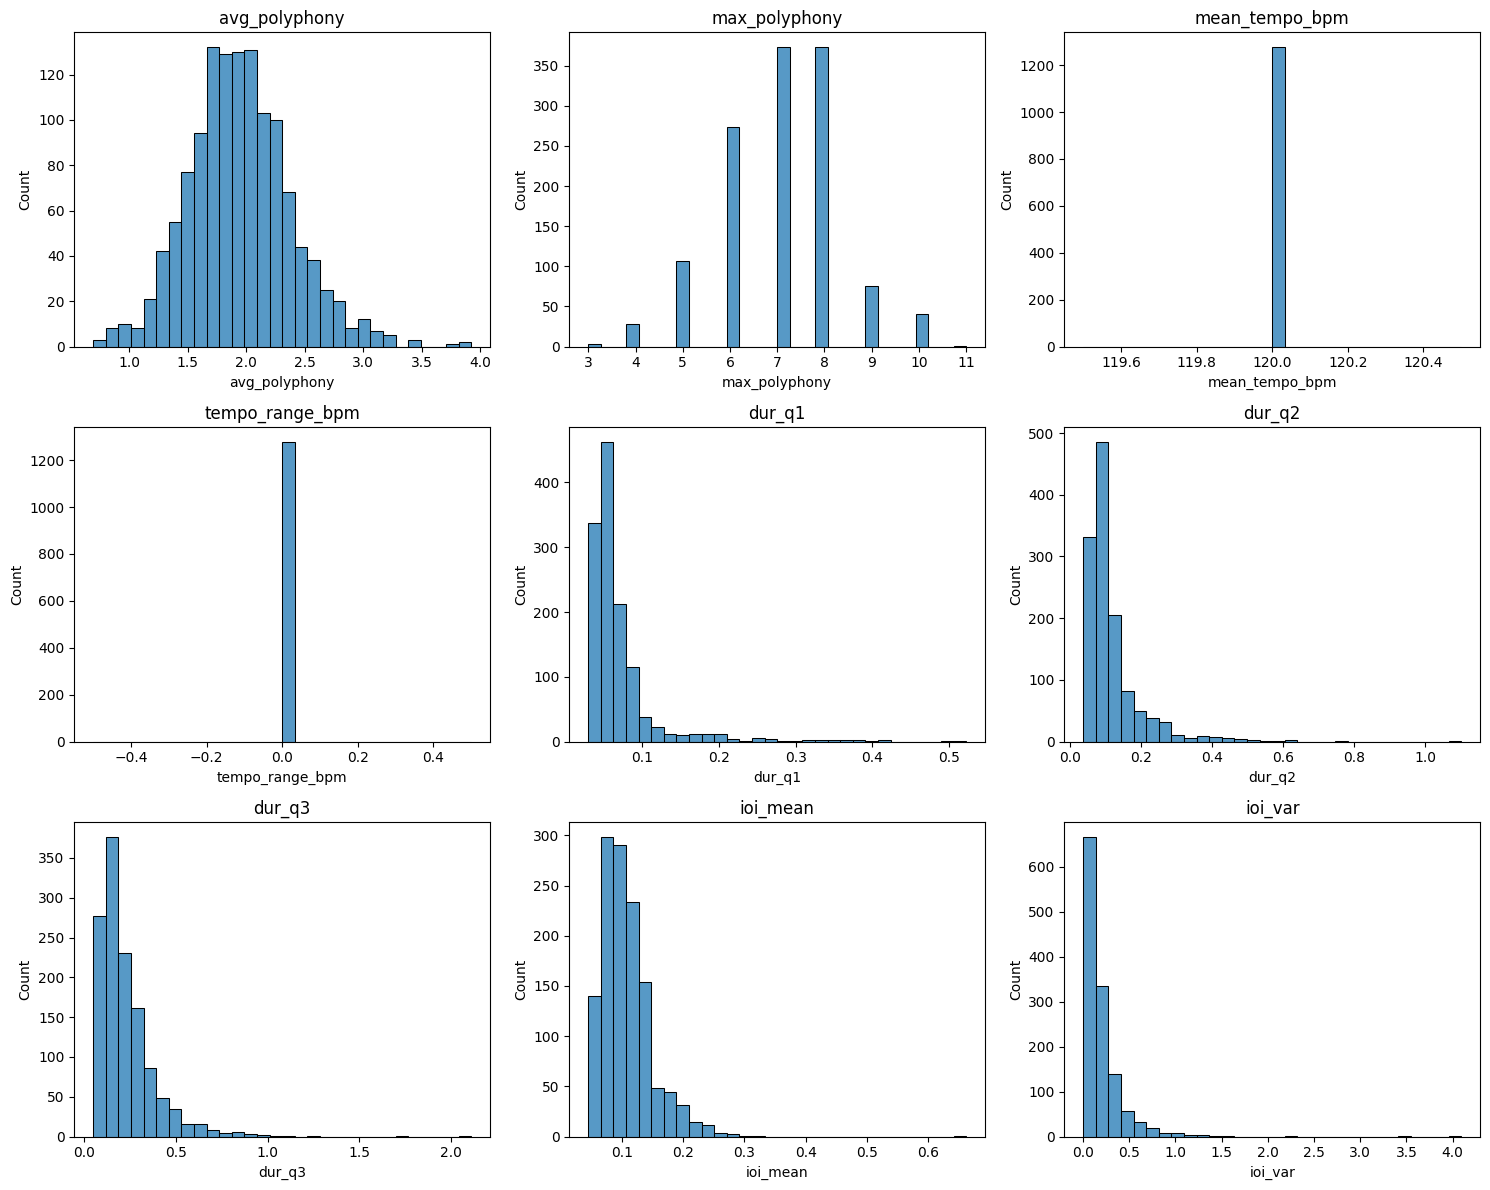

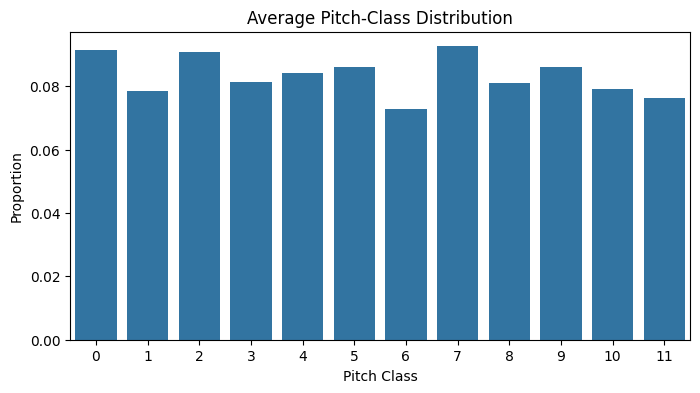

In [19]:
df_ext = pd.DataFrame(ext_records)
display(df_ext.describe(include='all'))

# Histogram plots for extended metrics
ext_metrics = [
    'avg_polyphony', 'max_polyphony',
    'mean_tempo_bpm', 'tempo_range_bpm',
    'dur_q1', 'dur_q2', 'dur_q3',
    'ioi_mean', 'ioi_var'
]
plt.figure(figsize=(15, 12))
for i, m in enumerate(ext_metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_ext[m].dropna(), bins=30)
    plt.title(m)
plt.tight_layout()
plt.show()

# Average pitch-class distribution
pc_cols = [f'pc_{i}' for i in range(12)]
pc_mean = df_ext[pc_cols].mean()
plt.figure(figsize=(8, 4))
sns.barplot(x=list(range(12)), y=pc_mean.values)
plt.title('Average Pitch-Class Distribution')
plt.xlabel('Pitch Class')
plt.ylabel('Proportion')
plt.show()

In [6]:
trimmed_dir = os.path.join(midi_dir, 'trimmed_20s')
os.makedirs(trimmed_dir, exist_ok=True)

for path in tqdm(midi_paths):
    pm = pretty_midi.PrettyMIDI(path)
    trimmed_pm = pretty_midi.PrettyMIDI()
    trimmed_pm.instruments = []
    for inst in pm.instruments:
        new_inst = pretty_midi.Instrument(program=inst.program,
                                          is_drum=inst.is_drum,
                                          name=inst.name)
        for note in inst.notes:
            if note.start < 20.0:
                new_end = min(note.end, 20.0)
                new_inst.notes.append(pretty_midi.Note(
                    velocity=note.velocity,
                    pitch=note.pitch,
                    start=note.start,
                    end=new_end
                ))
        trimmed_pm.instruments.append(new_inst)
    trimmed_pm.write(os.path.join(trimmed_dir, os.path.basename(path)))

100%|██████████| 1276/1276 [03:11<00:00,  6.68it/s]
